## ANÁLISIS VARIABLES DEL MODELO DE PREDICCIÓN DE PRECIOS DE BOLSA

In [2]:

import warnings
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [4]:
precios_diarios = pd.read_csv('../data_lake/business/precios-diarios.csv')
precios_diarios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9417 entries, 0 to 9416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   fecha   9417 non-null   object 
 1   precio  9417 non-null   float64
dtypes: float64(1), object(1)
memory usage: 147.3+ KB


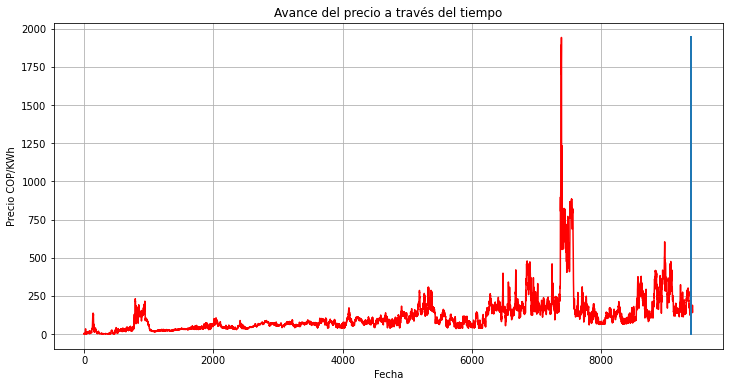

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(precios_diarios['precio'], "-k", color='red')
plt.grid()
plt.title('Avance del precio a través del tiempo')
plt.ylabel('Precio COP/KWh')
plt.xlabel('Fecha')

plt.plot([len(precios_diarios['precio']) - 24, len(precios_diarios['precio']) - 24], [min(precios_diarios['precio']), max(precios_diarios['precio'])], "-", linewidth=2);

Es posible observar el avance del tiempo con respecto al precio de bolsa, lo cual muestra en general una tendencia al alza y la linea azul representa la división del entrenamiento de los datos. 

### EDA Precio de Bolsa

En la función para predicción es necesaria la autocorrelación ACF simple:

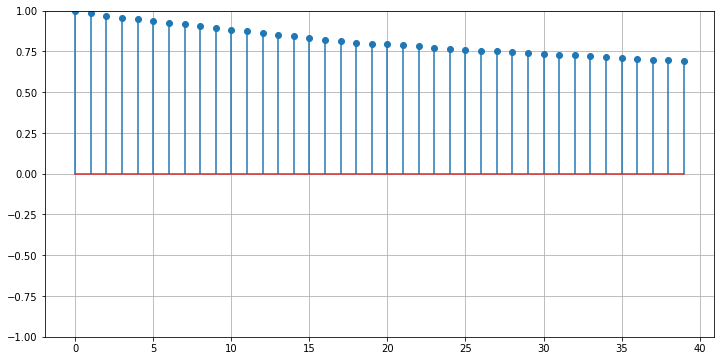

In [21]:
def acf_plot(z):
    plt.figure(figsize=(12, 6))
    acf_data = acf(z, fft=False)
    plt.stem(range(len(acf_data)), acf_data, use_line_collection=True)
    plt.ylim(-1, 1),
    plt.grid()



def pacf_plot(z):
    pacf_data = pacf(z)
    plt.stem(range(len(pacf_data)), pacf_data, use_line_collection=True)
    plt.ylim(-1, 1)
    plt.grid()
 

acf_plot(precios_diarios['precio'])

El primer paso a seguir es realizar una transformación de las variables pára poder utilizar el modelo de redes neuronales sencillo. Se realiza utilziando MinMax Scaler un escalador de sklearn bastante conocido. 

Text(0.5, 0, 'Fecha')

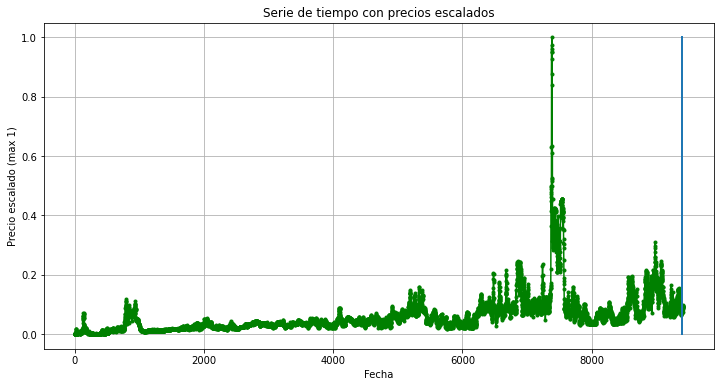

In [26]:

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(np.array(precios_diarios['precio']).reshape(-1, 1))
data_scaled = [u[0] for u in data_scaled]

plt.figure(figsize=(12, 6))
plt.plot(data_scaled, ".-k", color ="green")
plt.grid()
plt.plot(
    [len(data_scaled) - 24, len(data_scaled) - 24],
    [min(data_scaled), max(data_scaled)],
    linewidth=2,
);
plt.title('Serie de tiempo con precios escalados')
plt.ylabel('Precio escalado (max 1)')
plt.xlabel('Fecha')


Se procede a retirar la tendencia y finalmente y se puede observar la componente ciclica de la variable en la siguiente gráfica:

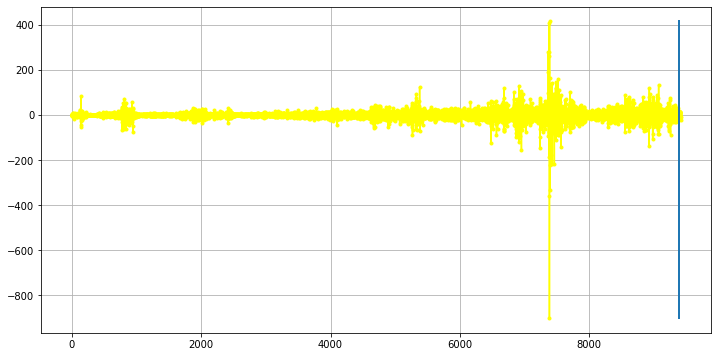

In [35]:

data_d1 = [precios_diarios['precio'][t] - precios_diarios['precio'][t - 1] for t in range(1, len(precios_diarios['precio']))]
plt.figure(figsize=(12, 6))
plt.plot(data_d1, ".-k", color = "yellow")
plt.grid()
plt.plot(
    [len(data_d1) - 24, len(data_d1) - 24],
    [min(data_d1), max(data_d1)],
    "-",
    linewidth=2,
    );

Es posible entonces retirar la componente ciclica mediante la resta de z[t] - z[t-12] siendo periodica en este intervalo.

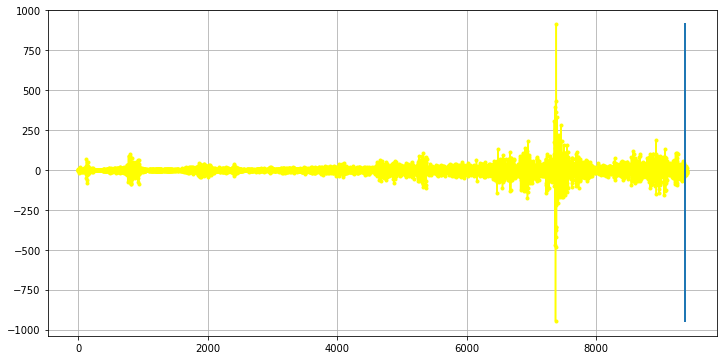

In [34]:
data_d1d12 = [data_d1[t] - data_d1[t - 12] for t in range(12, len(data_d1))]

plt.figure(figsize=(12, 6))
plt.plot(data_d1d12, ".-k", color ="yellow")
plt.grid()
plt.plot(
    [len(data_d1d12) - 24, len(data_d1d12) - 24],
    [min(data_d1d12), max(data_d1d12)],
    "-",
    linewidth=2,
);

El valor apropiado para retirar la forma ciclica (12) se encuentra utilizado se deduce de la manera siguiente:

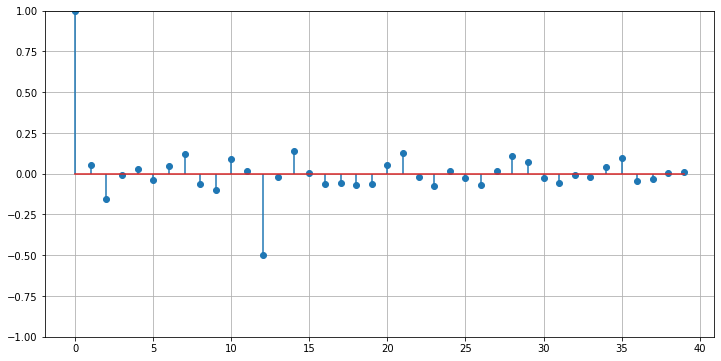

In [36]:
acf_plot(data_d1d12)


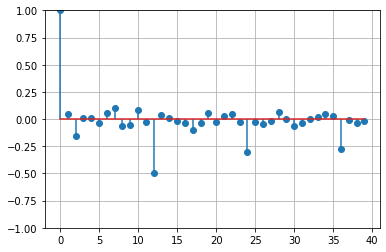

In [37]:
pacf_plot(data_d1d12)


Se realizará entonces el escalamiento de los valores con el mismo parametro Min Max Scaler:

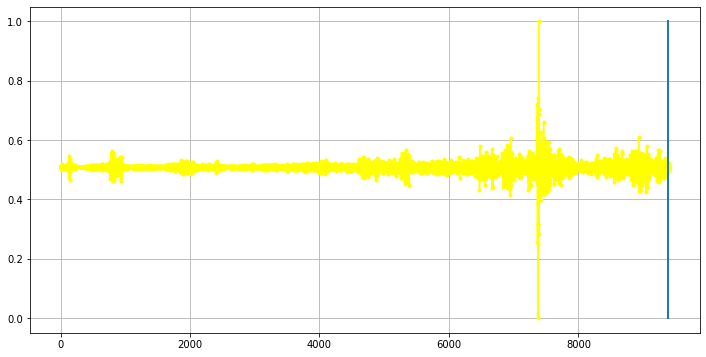

In [40]:
scaler = MinMaxScaler()
data_d1d12_scaled = scaler.fit_transform(np.array(data_d1d12).reshape(-1, 1))
data_d1d12_scaled = [u[0] for u in data_d1d12_scaled]


#
plt.figure(figsize=(12, 6))
plt.plot(data_d1d12_scaled, ".-k", color ="yellow")
plt.grid()
plt.plot(
    [len(data_d1d12_scaled) - 24, len(data_d1d12_scaled) - 24],
    [min(data_d1d12_scaled), max(data_d1d12_scaled)],
    "-",
    linewidth=2,
);

De esta manera se realiza el análisis de los datos y los cambios necesarios para la entrada del mismo al modelo (escalamiento y retirar la forma ciclica de la tendencia de la serie de tiempo analizada).